

<h1 align="center"><font size="5">Classification with Python</font></h1>

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import log_loss

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [7]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [8]:
df.shape

(346, 10)

### Convert to date time object 

In [9]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [10]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

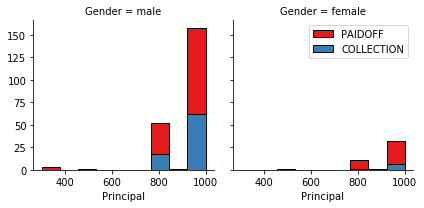

In [11]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

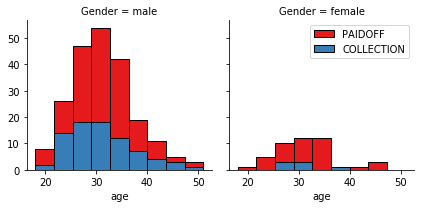

In [12]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

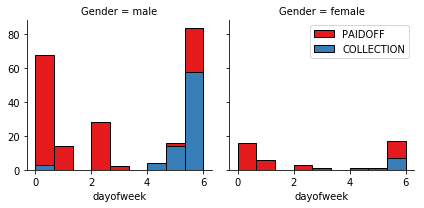

In [13]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [14]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [21]:
#df['loan_status'] = df['loan_status'].astype('int')
#pred_DF= df['loan_status']
#y=np.asarray(pred_DF)


#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
#pred_df = df['loan_status']
#y=np.asarray(pred_df)

y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [23]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

#### Train Test set

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print('Train Set', X_train.shape, y_train.shape)
print('Test Set', X_test.shape, y_test.shape)

Train Set (276, 8) (276,)
Test Set (70, 8) (70,)


In [25]:
from sklearn.neighbors import KNeighborsClassifier

#### Training

In [26]:
k = 5
#Train Model and Predict  
clf = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

#### Predicting 

In [28]:
y_pred = clf.predict(X_test)


#### Accuracy evaluation

In [29]:
np.mean(y_pred==y_test)

0.75714285714285712

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

print("Train set Accuracy in Percentage: ", accuracy_score(y_train, clf.predict(X_train))* 100)
print("Test set Accuracy in Percentage: ", accuracy_score(y_test, y_pred) * 100) 

Train set Accuracy in Percentage:  81.5217391304
Test set Accuracy in Percentage:  75.7142857143


In [31]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6,  9],
       [ 8, 47]])

#### Find best K

In [32]:
Ks=7
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    ConfustionMx.append(confusion_matrix(yhat,y_test,labels=['PAIDOFF','COLLECTION' ]))
mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571])

### Plot model accuracy for Different number of Neighbours

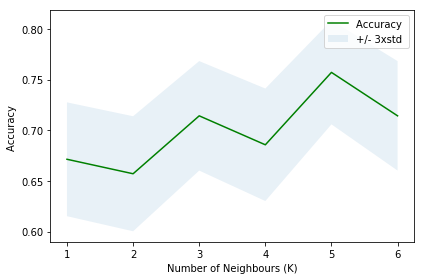

In [33]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

## Find the Best Value of K

In [34]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.757142857143 with k= 5


#### Jaccard Index

In [35]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, y_pred)


0.75714285714285712

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

 COLLECTION       0.43      0.40      0.41        15
    PAIDOFF       0.84      0.85      0.85        55

avg / total       0.75      0.76      0.75        70



#### F1 Score

In [38]:
from sklearn.metrics import f1_score
F1_score=f1_score(y_test, y_pred, average='weighted')  
print('F1_score is =', F1_score)

F1_score is = 0.754049616119


## Model Evaluation using Test set

In [3]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


#### Fixing the date 

In [41]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [42]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

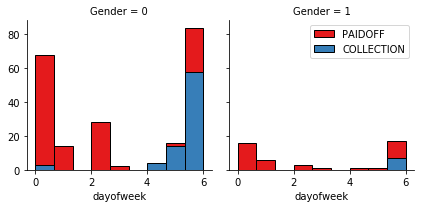

In [43]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [44]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [45]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [46]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [47]:
test_df[['Principal','terms','age','Gender','education']].head(10)

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor
5,700,15,33,0,High School or Below
6,1000,15,24,0,college
7,1000,30,32,0,Bechalor
8,800,15,27,1,college
9,1000,15,37,0,college


In [48]:
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [49]:
X_New = Test_Feature
X_New[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [50]:
y_new = test_df['loan_status'].values
y_new[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Now Normalizing the Test_features

In [51]:
X_New= preprocessing.StandardScaler().fit(X_New).transform(X_New)
X_New[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

#### predicting 

In [54]:
y_pred_new = clf.predict(X_New)
y_pred_new

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF'], dtype=object)

## Now applying my trained classifier on the new test data given in loan_test.csv file

# I will try to make functions for Evaluation so that we can use it for all classifiers. Wherever a specific evaluation is required I will handle it sperately 

## Evaluation KNN

In [61]:
def evaluation(classifier,feature_set,y_new,y_pred_new):
    print('The Accuracy,  KNN classifier on testset given =',accuracy_score(y_new,y_pred_new) * 100)
    print('The Jaccard_similarity_score,  KNN classifier on testset =', jaccard_similarity_score(y_new,y_pred_new))
    print('The F1_score,  KNN classifier on testset is =', f1_score(y_new, y_pred_new, average='weighted'))
    print('The Classification_report,  KNN classifier on testset is ' "\n", "\n",classification_report(y_new, y_pred_new))

In [62]:
evaluation(clf, X_New, y_new, y_pred_new)

The Accuracy,  KNN classifier on testset given = 70.3703703704
The Jaccard_similarity_score,  KNN classifier on testset = 0.703703703704
The F1_score,  KNN classifier on testset is = 0.6860670194
The Classification_report,  KNN classifier on testset is 
 
              precision    recall  f1-score   support

 COLLECTION       0.40      0.29      0.33        14
    PAIDOFF       0.77      0.85      0.81        40

avg / total       0.68      0.70      0.69        54



# Decision Tree

## Modelling 

In [2]:
from sklearn.tree import DecisionTreeClassifier

In [3]:
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dt_clf # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Model fitting

In [63]:
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Predicting 

In [64]:
y_pred_dt = dt_clf.predict(X_New)
y_pred_dt

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

## Evaluation Decision Tree

In [68]:
def evaluation_dt(classifier,feature_set,y_new,y_pred_new):
    print('The Accuracy,  Decision Tree classifier on testset given =',accuracy_score(y_new,y_pred_new) * 100)
    print('The Jaccard_similarity_score,  Decision Tree classifier on testset =', jaccard_similarity_score(y_new,y_pred_new))
    print('The F1_score,  Decision Tree classifier on testset is =', f1_score(y_new, y_pred_new, average='weighted'))
    print('The Classification_report,  Decision Tree classifier on testset is ' "\n", "\n",classification_report(y_new, y_pred_new))

In [69]:
evaluation_dt(dt_clf, X_New, y_new, y_pred_dt)

The Accuracy,  Decision Tree classifier on testset given = 72.2222222222
The Jaccard_similarity_score,  Decision Tree classifier on testset = 0.722222222222
The F1_score,  Decision Tree classifier on testset is = 0.736681887367
The Classification_report,  Decision Tree classifier on testset is 
 
              precision    recall  f1-score   support

 COLLECTION       0.48      0.71      0.57        14
    PAIDOFF       0.88      0.72      0.79        40

avg / total       0.77      0.72      0.74        54



# Support Vector Machine

## Modelling  & Fitting

In [70]:
from sklearn import svm
clf_svm=svm.SVC(kernel='rbf')
clf_svm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Predicting 

In [71]:
y_pred_svm = clf_svm.predict(X_New)
y_pred_svm

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [75]:
def evaluation_svm(classifier,feature_set,y_new,y_pred_new):
    print('The Accuracy,  SVM classifier on testset given =',accuracy_score(y_new,y_pred_new) * 100)
    print('The Jaccard_similarity_score,  SVM classifier on testset =', jaccard_similarity_score(y_new,y_pred_new))
    print('The F1_score,  SVM classifier on testset is =', f1_score(y_new, y_pred_new, average='weighted'))
    print('The Classification_report,  SVM classifier on testset is ' "\n", "\n",classification_report(y_new, y_pred_new))

In [76]:
evaluation_svm(clf_svm, X_New, y_new, y_pred_svm)

The Accuracy,  SVM classifier on testset given = 79.6296296296
The Jaccard_similarity_score,  SVM classifier on testset = 0.796296296296
The F1_score,  SVM classifier on testset is = 0.758350307729
The Classification_report,  SVM classifier on testset is 
 
              precision    recall  f1-score   support

 COLLECTION       0.80      0.29      0.42        14
    PAIDOFF       0.80      0.97      0.88        40

avg / total       0.80      0.80      0.76        54



# Logistic Regression

### Modelling & Fitting

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
clf_Lo_Reg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
clf_Lo_Reg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Predicting  

In [79]:
y_pred_Lo_Reg = clf_Lo_Reg.predict(X_New)
y_pred_Lo_Reg

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [80]:
pred_prob = clf_Lo_Reg.predict_proba(X_New)
pred_prob

array([[ 0.24523466,  0.75476534],
       [ 0.40836323,  0.59163677],
       [ 0.428088  ,  0.571912  ],
       [ 0.50550113,  0.49449887],
       [ 0.45560894,  0.54439106],
       [ 0.45319477,  0.54680523],
       [ 0.48466512,  0.51533488],
       [ 0.48408899,  0.51591101],
       [ 0.42592106,  0.57407894],
       [ 0.45152793,  0.54847207],
       [ 0.48126523,  0.51873477],
       [ 0.40763322,  0.59236678],
       [ 0.48664718,  0.51335282],
       [ 0.43638749,  0.56361251],
       [ 0.44319457,  0.55680543],
       [ 0.48758117,  0.51241883],
       [ 0.42033096,  0.57966904],
       [ 0.40417894,  0.59582106],
       [ 0.4864502 ,  0.5135498 ],
       [ 0.46497685,  0.53502315],
       [ 0.49525993,  0.50474007],
       [ 0.47007599,  0.52992401],
       [ 0.24932566,  0.75067434],
       [ 0.30500857,  0.69499143],
       [ 0.30638884,  0.69361116],
       [ 0.3206654 ,  0.6793346 ],
       [ 0.30748866,  0.69251134],
       [ 0.29032237,  0.70967763],
       [ 0.31326476,

In [82]:
def evaluation_Lo_Reg(classifier,feature_set,y_new,y_pred_new):
    print('The Accuracy,  Logistic regression classifier on testset given =',accuracy_score(y_new,y_pred_new) * 100)
    print('The Jaccard_similarity_score,  Logistic regression classifier on testset =', jaccard_similarity_score(y_new,y_pred_new))
    print('The F1_score,  Logistic regression classifier on testset is =', f1_score(y_new, y_pred_new, average='weighted'))
    print('The Log_loss,  Logistic regression classifier on testset is =', log_loss(y_new, pred_prob))
    print('The Classification_report,  Logistic regression classifier on testset is ' "\n", "\n",classification_report(y_new, y_pred_new))

In [83]:
evaluation_Lo_Reg(clf_Lo_Reg, X_New, y_new, y_pred_Lo_Reg)

The Accuracy,  Logistic regression classifier on testset given = 74.0740740741
The Jaccard_similarity_score,  Logistic regression classifier on testset = 0.740740740741
The F1_score,  Logistic regression classifier on testset is = 0.660426731079
The Log_loss,  Logistic regression classifier on testset is = 0.567215337991
The Classification_report,  Logistic regression classifier on testset is 
 
              precision    recall  f1-score   support

 COLLECTION       0.50      0.07      0.12        14
    PAIDOFF       0.75      0.97      0.85        40

avg / total       0.69      0.74      0.66        54



# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Accuracy(%) | F1-score| Jaccard | LogLoss|
|--------------------|---------|----------|---------|-----------|
| KNN                | 70.4    | .69      | NA      |  NA       |
| Decision Tree      | 72.2    | .73      | .72     |  NA       |
| SVM                | 79.6    | .75      | .79     |  NA       |
| LogisticRegression | 74      | .66      | .74     |  .57      |